<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center>Introduction to Anomaly Detection in Time Series with Keras</h2>


## Task 1: Project Overview and Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


## Task 2: Load and Inspect the S&P 500 Index Data

[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [3]:
df = pd.read_csv('S&P_500_Index_Data.csv', parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [4]:
df.shape

(8192, 2)

In [6]:
fig  = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.close, mode='lines', name='close' ))
fig.update_layout(showlegend=True)
fig.show()

## Task 3: Data Preprocessing

In [7]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close']  = scaler.transform(train[['close']])
test['close']  = scaler.transform(test[['close']])


## Task 4: Create Training and Test Splits

In [12]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [ ], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)
        

In [13]:
time_steps = 30

X_train, y_train = create_sequences(train[['close']], train.close, time_steps )
X_test, y_test = create_sequences(test[['close']], test.close, time_steps )

print(X_train.shape)

(6523, 30, 1)


## Task 5: Build an LSTM Autoencoder

In [14]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed


model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))
    
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

## Task 6: Train the Autoencoder

In [17]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size =32,
    validation_split = 0.1,
    callbacks = [es],
    shuffle=False
)

Train on 5870 samples, validate on 653 samples
Epoch 1/100
5870/5870 [==============================] - 25s 4ms/sample - loss: 0.1509 - val_loss: 0.2013
Epoch 2/100
5870/5870 [==============================] - 15s 3ms/sample - loss: 0.1133 - val_loss: 0.1061
Epoch 3/100
5870/5870 [==============================] - 15s 3ms/sample - loss: 0.0894 - val_loss: 0.0599
Epoch 4/100
5870/5870 [==============================] - 15s 3ms/sample - loss: 0.0795 - val_loss: 0.0398
Epoch 5/100
5870/5870 [==============================] - 15s 3ms/sample - loss: 0.0714 - val_loss: 0.0631
Epoch 6/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0775 - val_loss: 0.0444
Epoch 7/100
5870/5870 [==============================] - 17s 3ms/sample - loss: 0.0717 - val_loss: 0.0330
Epoch 8/100
5870/5870 [==============================] - 17s 3ms/sample - loss: 0.0751 - val_loss: 0.0456
Epoch 9/100
5870/5870 [==============================] - 17s 3ms/sample - loss: 0.0763 - val_loss: 0.0434

## Task 7: Plot Metrics and Evaluate the Model

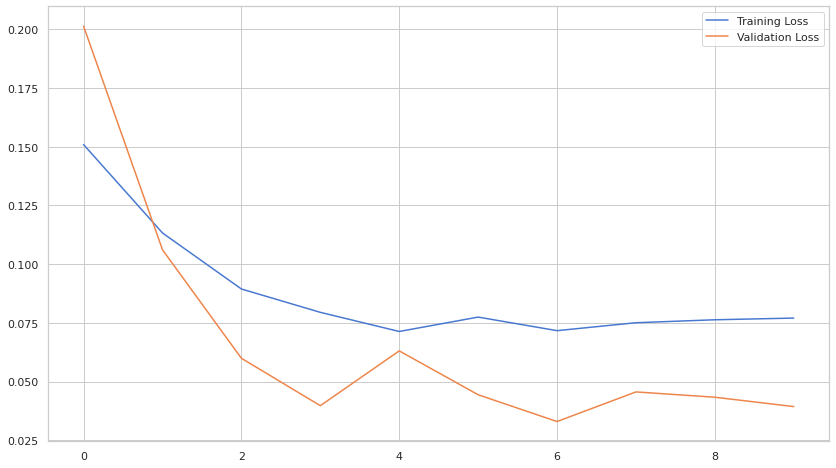

In [18]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [20]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred-X_train), axis=1), columns=["Error"])

In [21]:
model.evaluate(X_test, y_test)

1609/1609 [==============================] - 2s 1ms/sample - loss: 0.2997


0.2997494750025852

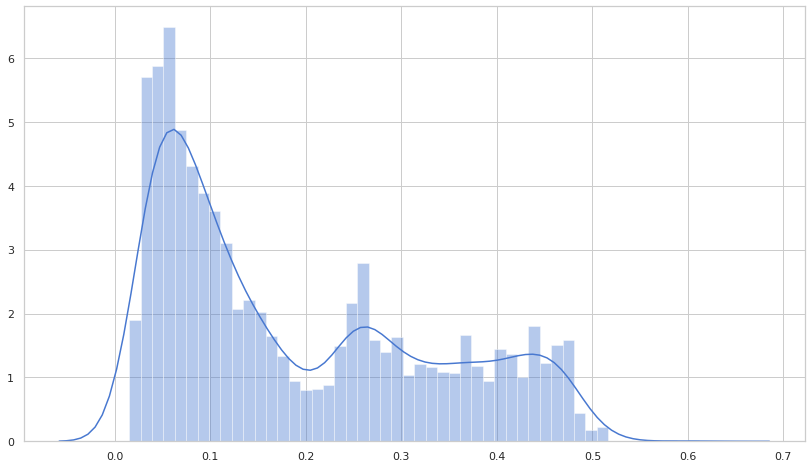

In [22]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [23]:
threshold = 0.65

In [24]:
X_test_pred = model.predict(X_test)
test_mae_loss  = np.mean(np.abs(X_test_pred-X_test), axis=1)

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [25]:
test_score_df = pd.DataFrame(test[time_steps:])

test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anamaly'] = test_score_df.loss>test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [26]:
test_score_df.head()

,date,close,loss,threshold,anamaly
6583,2012-02-08,1.216856,0.062708,0.65,False
6584,2012-02-09,1.221625,0.064258,0.65,False
6585,2012-02-10,1.199313,0.064334,0.65,False
6586,2012-02-13,1.221194,0.055173,0.65,False
6587,2012-02-14,1.218150,0.055719,0.65,False


In [27]:
test_score_df.tail()

,date,close,loss,threshold,anamaly
8187,2018-06-25,4.493228,0.566041,0.65,False
8188,2018-06-26,4.507583,0.616114,0.65,False
8189,2018-06-27,4.451431,0.629351,0.65,False
8190,2018-06-28,4.491406,0.662492,0.65,True
8191,2018-06-29,4.496343,0.652340,0.65,True


In [28]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss, mode='lines',
                         name="test Loss"))

fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold, mode='lines',
name="Threshold"))

fig.update_layout(showlegend=True)
fig.show()

In [29]:
anomalies = test_score_df[test_score_df.anamaly==True]
anomalies.head()

,date,close,loss,threshold,anamaly
7474,2015-08-25,2.457439,0.674271,0.65,True
7475,2015-08-26,2.632149,0.749474,0.65,True
7476,2015-08-27,2.745147,0.665134,0.65,True
8091,2018-02-06,4.440671,0.748892,0.65,True
8092,2018-02-07,4.408365,0.765130,0.65,True


In [31]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date,
                         y=scaler.inverse_transform(test[time_steps:].close), mode='lines',
                         name="Close"))

fig.add_trace(go.Scatter(x=anomalies.date,
                         y=scaler.inverse_transform(anomalies.close), mode='markers',
name="Threshold"))

fig.update_layout(showlegend=True)
fig.show()